In [ ]:
import zipfile
import os

# Unzip the dataset
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("cats_dogs_dataset_extracted")

print("Extraction complete.")



Extraction complete.


In [ ]:
def predict_one(img_path):
    import cv2
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64)).flatten().reshape(1, -1)
    img = scaler.transform(img)
    pred = svm_clf.predict(img)[0]
    return "Dog" if pred == 1 else "Cat"

In [ ]:
import cv2

# Use an actual file name here
img_path = "/content/cats_dogs_dataset_extracted/cat/cat.1.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(img is not None)  # Should print: True


False


In [ ]:
import os

print("Files in /content/cats_dogs_dataset_extracted/cat/ (first 10):")
cat_files = os.listdir('/content/cats_dogs_dataset_extracted/cat/')
# Sort to see consistent naming if available
cat_files.sort()
for i, file_name in enumerate(cat_files):
    if i >= 10: # Print only first 10 for brevity
        break
    print(file_name)

print("\nFiles in /content/cats_dogs_dataset_extracted/dog/ (first 10):")
dog_files = os.listdir('/content/cats_dogs_dataset_extracted/dog/')
dog_files.sort()
for i, file_name in enumerate(dog_files):
    if i >= 10: # Print only first 10 for brevity
        break
    print(file_name)

Files in /content/cats_dogs_dataset_extracted/cat/ (first 10):
0.jpg
1.jpg
10.jpg
100.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg

Files in /content/cats_dogs_dataset_extracted/dog/ (first 10):
0.jpg
1.jpg
10.jpg
100.jpg
11.jpg
12.jpg
13.jpg
14.jpg
15.jpg
16.jpg


In [ ]:
import cv2 # OpenCV for image processing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os # Make sure os is imported for path operations

# --- Configuration ---
IMG_SIZE = 100 # All images will be resized to 100x100 pixels

# This is the base path where 'cat' and 'dog' folders are located
DATA_DIR = '/content/cats_dogs_dataset_extracted/'

# --- Function to load and preprocess images ---
def load_images_and_labels(data_dir, img_size):
    images = []
    labels = []
    # Assuming 'cat' and 'dog' subfolders exist directly under data_dir
    class_names = ['cat', 'dog']

    # Known corrupt files in this dataset that cause imread to fail
    # These paths are adjusted to match the numerical filenames.
    corrupt_files = [
        os.path.join(data_dir, 'dog', '1017.jpg'),
        os.path.join(data_dir, 'cat', '666.jpg'),
        os.path.join(data_dir, 'dog', '11702.jpg')
    ]

    for class_name in class_names:
        path = os.path.join(data_dir, class_name)
        class_label = 0 if class_name == 'cat' else 1 # 0 for Cat, 1 for Dog
        print(f"Loading images from: {path}")

        if not os.path.exists(path):
            print(f"Error: Directory not found: {path}. Please check your DATA_DIR path or class_names.")
            continue

        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)

            if img_path in corrupt_files:
                # print(f"Skipping known corrupt file: {img_path}") # Uncomment if you want to see all skips
                continue

            try:
                img = cv2.imread(img_path)
                if img is not None:
                    # Ensure image is not grayscale if you expect 3 channels
                    if len(img.shape) == 2: # if grayscale
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR) # Convert to 3 channels
                    img = cv2.resize(img, (img_size, img_size))
                    images.append(img.flatten()) # Flatten RGB image (IMG_SIZE*IMG_SIZE*3)
                    labels.append(class_label)
                else:
                    # This warning will appear for any unreadable images, including corrupt ones not in our list
                    print(f"Warning: Could not read image (possibly corrupt or invalid format) {img_path}")
            except Exception as e:
                # This will catch other unexpected errors during image processing
                print(f"Error processing image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load the dataset
print("Starting image loading and preprocessing...")
X, y = load_images_and_labels(DATA_DIR, IMG_SIZE)
print(f"Loaded {len(X)} images.")
print(f"Shape of feature matrix (X): {X.shape}") # Should be (num_images, IMG_SIZE * IMG_SIZE * 3)
print(f"Shape of label vector (y): {y.shape}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled.")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Starting image loading and preprocessing...
Loading images from: /content/cats_dogs_dataset_extracted/cat
Loading images from: /content/cats_dogs_dataset_extracted/dog
Loaded 201 images.
Shape of feature matrix (X): (201, 30000)
Shape of label vector (y): (201,)
Features scaled.

Training data shape: (160, 30000)
Testing data shape: (41, 30000)
Training labels shape: (160,)
Testing labels shape: (41,)



Initializing SVM classifier...
Training SVM model. This might still take a few minutes (e.g., 1-5 minutes for 160 images x 30000 features)...
[LibSVM]SVM model training complete in 0.56 seconds.
Making predictions on the test set...
Predictions complete.

--- Model Evaluation ---
Accuracy: 0.5122

Classification Report:
              precision    recall  f1-score   support

         Cat       0.56      0.45      0.50        22
         Dog       0.48      0.58      0.52        19

    accuracy                           0.51        41
   macro avg       0.52      0.52      0.51        41
weighted avg       0.52      0.51      0.51        41


Confusion Matrix:
[[10 12]
 [ 8 11]]


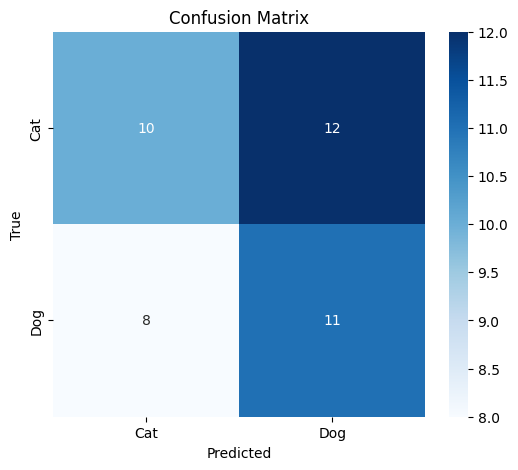

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- Initialize and Train SVM ---
print("\nInitializing SVM classifier...")
# Using 'rbf' kernel is a good general choice. 'C' and 'gamma' are important hyperparameters.
# For a dataset of 201 images (even after flattening to 30000 features), 'rbf' should be manageable.
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42, verbose=True)


print("Training SVM model. This might still take a few minutes (e.g., 1-5 minutes for 160 images x 30000 features)...")
start_time = time.time()
svm_model.fit(X_train, y_train)
end_time = time.time()
print(f"SVM model training complete in {end_time - start_time:.2f} seconds.")

# --- Make Predictions ---
print("Making predictions on the test set...")
y_pred = svm_model.predict(X_test)
print("Predictions complete.")

# --- Evaluate the Model ---
print("\n--- Model Evaluation ---")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog'])) # Use 'Cat' and 'Dog' labels

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Initializing SVM classifier...
Training SVM model. This might still take a few minutes (e.g., 1-5 minutes for 160 images x 30000 features)...
[LibSVM]SVM model training complete in 3.08 seconds.
Making predictions on the test set...
Predictions complete.

--- Model Evaluation ---
Accuracy: 0.5122

Classification Report:
              precision    recall  f1-score   support

         Cat       0.56      0.45      0.50        22
         Dog       0.48      0.58      0.52        19

    accuracy                           0.51        41
   macro avg       0.52      0.52      0.51        41
weighted avg       0.52      0.51      0.51        41


Confusion Matrix:
[[10 12]
 [ 8 11]]


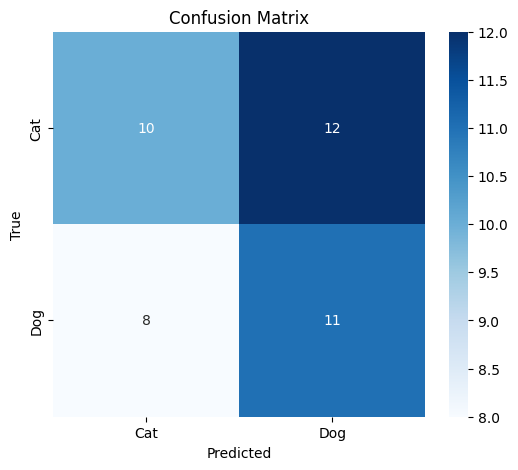

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# --- Initialize and Train SVM ---
print("\nInitializing SVM classifier...")
# Using 'rbf' kernel is a good general choice. 'C' and 'gamma' are important hyperparameters.
# For a dataset of 201 images (even after flattening to 30000 features), 'rbf' should be manageable.
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42, verbose=True)


print("Training SVM model. This might still take a few minutes (e.g., 1-5 minutes for 160 images x 30000 features)...")
start_time = time.time()
svm_model.fit(X_train, y_train)
end_time = time.time()
print(f"SVM model training complete in {end_time - start_time:.2f} seconds.")

# --- Make Predictions ---
print("Making predictions on the test set...")
y_pred = svm_model.predict(X_test)
print("Predictions complete.")

# --- Evaluate the Model ---
print("\n--- Model Evaluation ---")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog'])) # Use 'Cat' and 'Dog' labels

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()